# Second Internship Report by Shaig Hamzaliyev

## Introduction

Aim of this report is investigating the best fit for the outgoing signal of LIDAR Full Waveform. Mostly Gaussian function was used for this purpose however Exponential Gaussian is also an option. Here we will fit both functions to the outgoing signal. By doing some statistical analysis we will try to define the best fit.

Before getting into fitting we should get georeferenced signals from NEON file. Most data preparations were done in the first internship (see https://github.com/ShaigHamzaliyev/LIDAR-FWF-Data-Processing/blob/add-license-1/Lidar%20-%20FWF%20processing%20CookBook.ipynb). However as a first task, I created a small library called 'neon_fwf.py' for creating HDF file from ASCII (https://github.com/ShaigHamzaliyev/LIDAR-FWF-Data-Processing/blob/add-license-1/neon_fwf.py) and compare results with the binary reader (https://github.com/Rheinwalt/pulsewaves). 'neon_fwf.py' file contains 4 functions 'header', 'data_extraction', 'georeferencing', 'create_hdf'. As the first three functions are almost the same with functions from the first internship here I am going to show the last function. But first, we should load some data by using our small library.

In [1]:
# importing some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

If the notebook is in the same directory with .py file we can simply import it. Next step would be calling create_hdf function. This function requires two arguments. The first path of ASCII file second path/name of HDF file which will be created.

In [2]:
# This is just for creating your small hdf file by using neon_fwf.py
import neon_fwf
path = '/home/shaig93/Documents/new_one.asc'
neon_fwf.create_hdf(path, 'nwo.hdf')

In [2]:
# Reading hdf files
h = h5py.File('nwo.hdf', 'r') # ASCII reader
h2 = h5py.File('NEON_D06_KONZ_DP1_L037-1_2019071214_translate.hdf', 'r') # Binary reader

Understanding the structure of HDF files is very crucial as it will be helpful when we will go through the create_hdf function. 

After reading HDF files we can use .keys() method for having the basic idea of the structure. 

In [4]:
h.keys(), h2.keys()

(<KeysViewHDF5 ['Amplitude', 'Index', 'XYZ']>,
 <KeysViewHDF5 ['Amplitude', 'Index', 'XYZ']>)

We have 3 keys 'Amplitude', 'Index', 'XYZ'. About 'Index' - as our signals will be in one continuous array it is important to have 'Index' to determine the starting index of each signal.

In [3]:
index = h['Index']
amp = h['Amplitude']
elv = h['XYZ'][:, 2]

In [10]:
amp.shape

(35297840, 2)

XYZ is containing x, y, z values. Amplitude is a NumPy ndarray. The first column stands for intensity value, the second column stands for pulse type. If it is 0 it means the pulse is outgoing if it is other than 0 then it is returning. However, sometimes we might get multiple returning pulses in this case 1 is first returning and 2 is second returning pulse (same logic for n).

In [10]:
amp[index2[19]:index2[20]][:5], amp[index2[19]:index2[20]][52:57], amp[index2[19]:index2[20]][78:83]

(array([[207,   0],
        [210,   0],
        [211,   0],
        [209,   0],
        [212,   0]], dtype=int32),
 array([[209,   1],
        [210,   1],
        [210,   1],
        [209,   1],
        [210,   1]], dtype=int32),
 array([[327,   1],
        [325,   1],
        [325,   1],
        [318,   1],
        [315,   1]], dtype=int32))

In [8]:
index.shape

(374999,)

In [11]:
# Reading second hdf file (Binary)
index2 = h2['Index'][:index.shape[0]]
amp2 = h2['Amplitude'][:amp.shape[0]]
elv2 = h2['XYZ'][:elv.shape[0], 2]

As header, data_extraction and georeferencing functions were discussed in the previous report here only create_hdf function will be discussed.

The first step is calling data_extraction (cell 15, line 4) function, however, we do not need all outputs of it. Only outgoing pulses and returning signals will be called. As we mentioned before we want to have 0, 1, 2 etc for each intensity value for differentiation of signal type. Line 6-8 is looping over outgoing signals. For each outgoing signal, we are creating an array of zeros (based on the length of the signal) and concatenating them with corresponding outgoing signal along the second axis (np.c_).

From line 12 to 20 we are applying the same idea to returning pulse. However, sometimes we have multiple returns and it causes a little problem. Problem is when there is only one returning signal (which we need assign 1) array shape will be sam with the number of data points in the signal. However, with multiple returns shape of an array is equal to the number of returning signals and as we want to assign different numbers for each returning signal we can not just concatenate them. For having little intuition let's check an example in the next cell.

In [11]:
returning_1 = np.array([0, 1, 2, 3])
returning_multiple = np.array([np.array([4, 5, 6, 7]), np.array([8, 9, 0])])
returning_1.shape, returning_multiple.shape

((4,), (2,))

returning_multiple has more elements (intensity values) in overall. However, the shape is 2. That is why it needs another loop.

In [12]:
returning_multiple # numpy array with elements of numpy arrays

array([array([4, 5, 6, 7]), array([8, 9, 0])], dtype=object)

Now as the data structure is clear we can go through lines 12-20 in a more detailed way. We do not have multiple returns more than 2 in our data and for finding single returns we are making a condition inline 13. Else condition is for multiple returns. As we explained in the example in previous cell shape will be less than 5. In this condition, we need another loop for dealing with each returning signal separately. The number which we will assign for each intensity value will be j + 1 (where j is the index of returning sample). The reason for j + 1 is python starts counting from 0 and we are assigning 0 to outgoing signal. In this case, our first returning signal will be 0 + 1.

Inline 25 we are going concatenate each outgoing signal with the corresponding returning signal. 

Next step is creating 'Index'. For that, we are going to use the shape of outgoing + returning signals. Creating XYZ is quite straightforward by calling georeferencing function. 

In [13]:
def create_hdf(path, name_hdf):
    import numpy as np
    import h5py
    ouinp, rtinp, _, _, _ = data_extraction(path)
    ou_zr = []
    for i in range(len(ouinp)):
        zro = np.zeros(ouinp[i].shape)
        ouinp_ = np.c_[ouinp[i], zro]
        ou_zr.append(ouinp_)
    ou_zrnp = np.array(ou_zr)
    rto = []
    for i in range(len(rtinp)):
        if len(rtinp[i]) > 5:
            one = np.ones(rtinp[i].shape)
            rtinp_ = np.c_[rtinp[i], one]
        else:
            rtinp_ = []
            for j in range(len(rtinp[i])):
                two_or_more = np.ones(np.concatenate(rtinp[i][j]).shape) * (j + 1)
                rrt = np.c_[np.concatenate(rtinp[i][j]), two_or_more]
                rtinp_.append(rrt)
        rto.append(rtinp_)
    rto_np = np.array(rto)
    conc = []
    for i in range(len(ouinp)):
        cnc = np.concatenate((ou_zrnp[i], rto_np[i]))
        conc.append(cnc)
    conc_np = np.array(conc)
    amplitude = np.vstack((conc_np))
    prv = 0
    idx = [0]
    for i in range(len(conc_np)):
        shp = conc_np[i].shape[0]
        prv += shp
        idx.append(prv)
    Index = np.array(idx)
    XYZ = georeferencing(path)
    f = h5py.File(name_hdf, 'w')
    f.create_dataset('Amplitude', data = amplitude, dtype='i')
    f.create_dataset('Index', data = Index, dtype='i')
    f.create_dataset('XYZ', data = XYZ) 

## Comparison of Binary Reader and ASCII Reader

For comparing outputs of Binary reader and ASCII reader 'np.array_equal' was used.

In [14]:
np.array_equal(amp2[:, 0], amp[:, 0])

True

Here we compared ~374999 arrays. For that array_equal function from NumPy library was used. This function returns True if two arrays have the same shape and elements, otherwise, it will return False.

In the next cells, we will show signals from binary and ASCII reader visually.

Z minimum (Outgoing (ASCII reader)) -  1327.9764499999999  - Intensity min (Outgoing(ASCII reader)) -  207
Z maximum (Outgoing (ASCII reader)) -  1336.04  - Intensity max (Outgoing(ASCII reader)) -  525
Z min (Returning (ASCII reader)) -  306.55165000000034  - Intensity min (Returning(ASCII reader)) -  204
Z max (Returning (ASCII reader)) -  314.8864400000002  - Intensity max (Returning(ASCII reader)) -  345


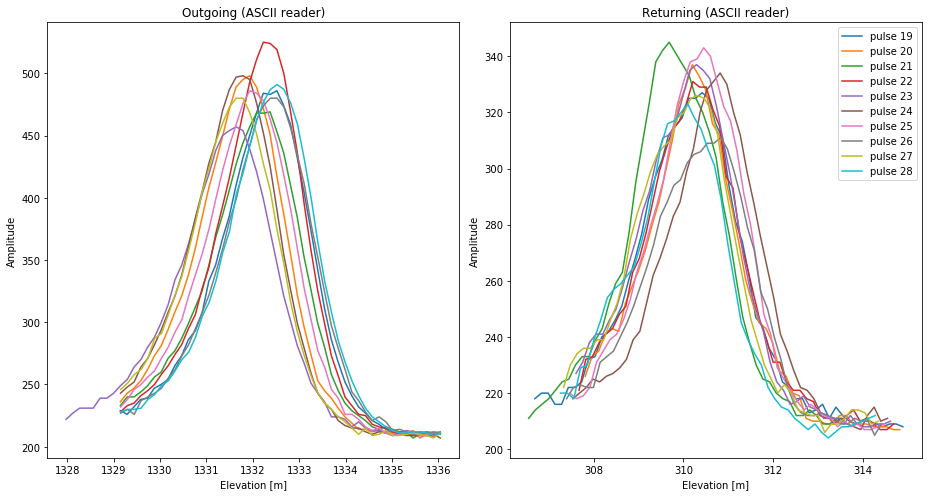

In [15]:
import h5py
from matplotlib import pyplot as pl

g = h
amp = g['Amplitude']
xyz = g['XYZ']
idx = g['Index']

fg, ax = pl.subplots(1, 2, figsize=(13, 7))
z_min = np.ones(1) * 9999
z_max = np.zeros(1)
amp_min = np.ones(1) * 9999
amp_max = np.zeros(1)
for i in range(440, 450):
    a = amp[idx[i]:idx[i+1], :]
    z = xyz[idx[i]:idx[i+1], 2]
    z = z[a[:,1] == 0]
    a = a[a[:,1] == 0, 0]
    if z.min() < z_min:
        z_min = z.min()
    if z_max < z.max():
        z_max = z.max()
    if a.min() < amp_min:
        amp_min = a.min()
    if amp_max < a.max():
        amp_max = a.max()
    ax[0].plot(z, a, label = 'pulse %i' % i)

ax[0].set_xlabel('Elevation [m]')
ax[0].set_ylabel('Amplitude')
print('Z minimum (Outgoing (ASCII reader)) - ', z_min, ' - Intensity min (Outgoing(ASCII reader)) - ', amp_min)
print('Z maximum (Outgoing (ASCII reader)) - ', z_max, ' - Intensity max (Outgoing(ASCII reader)) - ', amp_max)
ax[0].set_title('Outgoing (ASCII reader)')
z_min = np.ones(1) * 9999
z_max = np.zeros(1)
amp_min = np.ones(1) * 9999
amp_max = np.zeros(1)
for i in range(19, 29):
    a = amp[idx[i]:idx[i+1], :]
    z = xyz[idx[i]:idx[i+1], 2]
    z = z[a[:,1] > 0]
    a = a[a[:,1] > 0, 0]
    if z.min() < z_min:
        z_min = z.min()
    if z_max < z.max():
        z_max = z.max()
    if a.min() < amp_min:
        amp_min = a.min()
    if amp_max < a.max():
        amp_max = a.max()
    ax[1].plot(z, a, label = 'pulse %i' % i)
ax[1].set_xlabel('Elevation [m]')
ax[1].set_ylabel('Amplitude')
print('Z min (Returning (ASCII reader)) - ', z_min, ' - Intensity min (Returning(ASCII reader)) - ', amp_min)
print('Z max (Returning (ASCII reader)) - ', z_max, ' - Intensity max (Returning(ASCII reader)) - ', amp_max)
ax[1].set_title('Returning (ASCII reader)')
pl.legend()
pl.tight_layout()
pl.show()

###### Figure number 1: Random Pulses from ASCII reader.

Z minimum (Outgoing (Binary Reader)) -  1327.9764499999999  - Intensity min (Binary(ASCII reader)) -  207
Z maximum (Outgoing (Binary Reader)) -  1336.04  - Intensity max (Binary(ASCII reader)) -  525
Z minimum (Returning (Binary Reader)) -  306.55165000000034  - Intensity min (Returning(Binary reader)) -  204
Z maximum (Returning (Binary Reader)) -  314.8864400000002  - Intensity max (Returning(Binary reader)) -  345


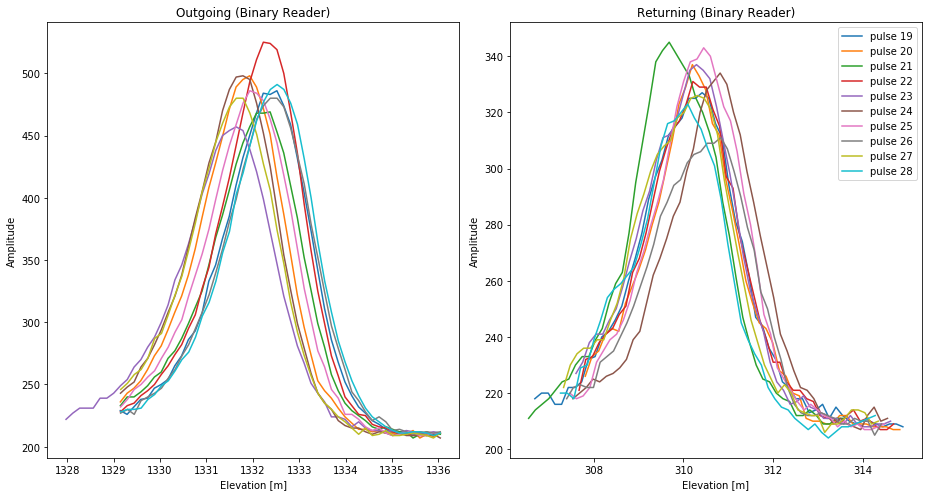

In [16]:
import h5py
from matplotlib import pyplot as pl

g = h2
amp = g['Amplitude']
xyz = g['XYZ']
idx = g['Index']

fg, ax = pl.subplots(1, 2, figsize=(13, 7))
z_min = np.ones(1) * 9999
z_max = np.zeros(1)
amp_min = np.ones(1) * 9999
amp_max = np.zeros(1)
for i in range(440, 450):
    a = amp[idx[i]:idx[i+1], :]
    z = xyz[idx[i]:idx[i+1], 2]
    z = z[a[:,1] == 0]
    a = a[a[:,1] == 0, 0]
    if z.min() < z_min:
        z_min = z.min()
    if z_max < z.max():
        z_max = z.max()
    if a.min() < amp_min:
        amp_min = a.min()
    if amp_max < a.max():
        amp_max = a.max()
    ax[0].plot(z, a, label = 'pulse %i' % i)

ax[0].set_xlabel('Elevation [m]')
ax[0].set_ylabel('Amplitude')
print('Z minimum (Outgoing (Binary Reader)) - ', z_min, ' - Intensity min (Binary(ASCII reader)) - ', amp_min)
print('Z maximum (Outgoing (Binary Reader)) - ', z_max, ' - Intensity max (Binary(ASCII reader)) - ', amp_max)
ax[0].set_title('Outgoing (Binary Reader)')
z_min = np.ones(1) * 9999
z_max = np.zeros(1)
amp_min = np.ones(1) * 9999
amp_max = np.zeros(1)
for i in range(19, 29): 
    a = amp[idx[i]:idx[i+1], :]
    z = xyz[idx[i]:idx[i+1], 2]
    z = z[a[:,1] > 0]
    a = a[a[:,1] > 0, 0]
    if z.min() < z_min:
        z_min = z.min()
    if z_max < z.max():
        z_max = z.max()
    if a.min() < amp_min:
        amp_min = a.min()
    if amp_max < a.max():
        amp_max = a.max()
    ax[1].plot(z, a, label = 'pulse %i' % i)

ax[1].set_xlabel('Elevation [m]')
ax[1].set_ylabel('Amplitude')
print('Z minimum (Returning (Binary Reader)) - ', z_min, ' - Intensity min (Returning(Binary reader)) - ', amp_min)
print('Z maximum (Returning (Binary Reader)) - ', z_max, ' - Intensity max (Returning(Binary reader)) - ', amp_max)
ax[1].set_title('Returning (Binary Reader)')
pl.legend()
pl.tight_layout()
pl.show()

###### Figure number 2: Random Pulses from Binary reader.

Until now, most of the returning signals were single return. For the sake of showing multiple returns, I am uploading another dataset.

In [3]:
h_ = h5py.File('mod.hdf', 'r')
index_ = h_['Index'][:25000]
amp_ = h_['Amplitude'][:25000]
elv_ = h_['XYZ'][:, 2][:25000]

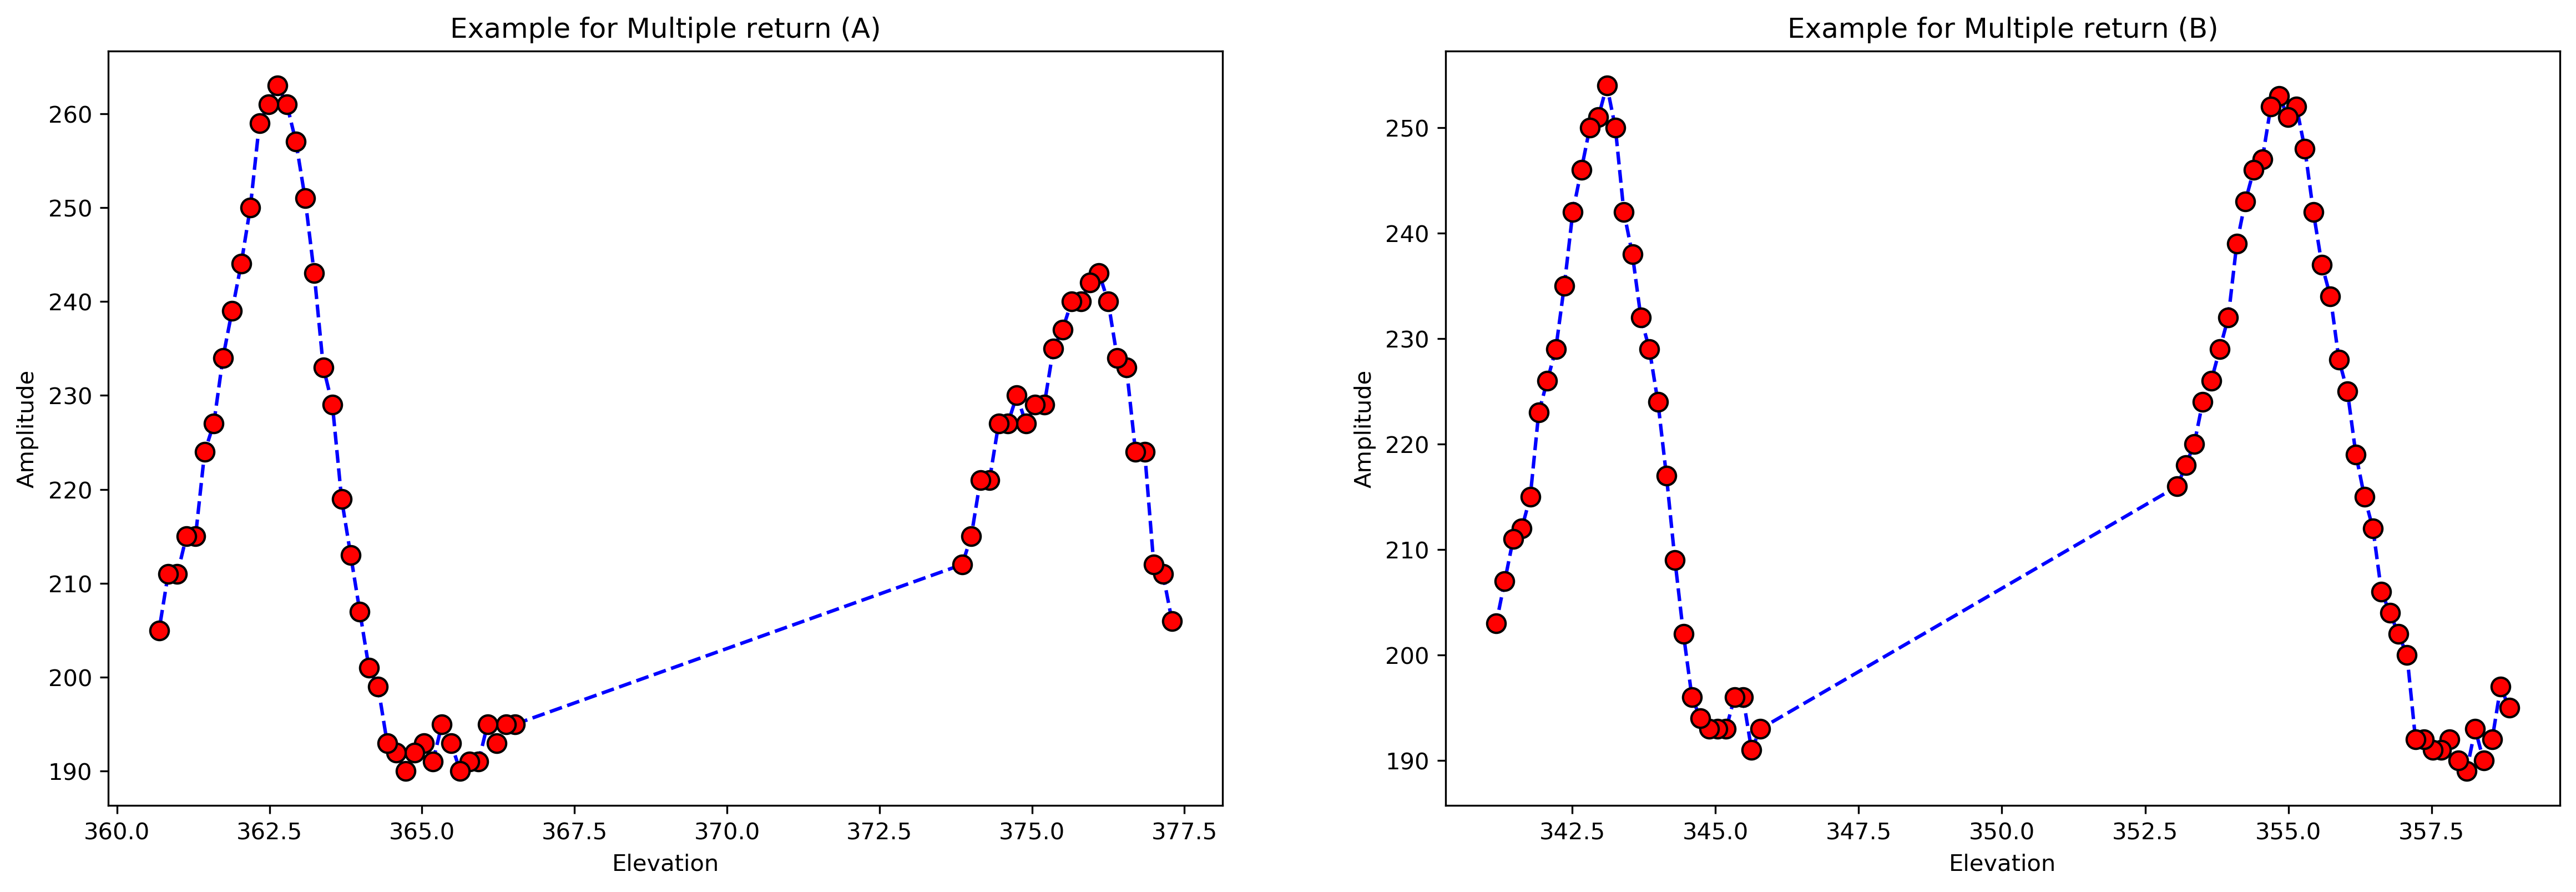

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (19, 6), dpi = 300)
ax[0].plot(elv_[index_[19]:index_[20]][amp_[index_[19]:index_[20]][:, 1] != 0], 
         amp_[index_[19]:index_[20]][amp_[index_[19]:index_[20]][:, 1] != 0][:, 0], linestyle='--', marker='o',
           markersize=8, markeredgecolor='black', markerfacecolor='red', color='b')
ax[1].plot(elv_[index_[129]:index_[130]][amp_[index_[129]:index_[130]][:, 1] != 0], 
         amp_[index_[129]:index_[130]][amp_[index_[129]:index_[130]][:, 1] != 0][:, 0],linestyle='--', marker='o',
           markersize=8, markeredgecolor='black', markerfacecolor='red', color='b')
ax[0].set_title('Example for Multiple return (A)')
ax[1].set_title('Example for Multiple return (B)')
for i in range(2):
    ax[i].set_xlabel('Elevation')
    ax[i].set_ylabel('Amplitude')
plt.savefig('outgo.png', dpi = 300) 

###### Figure number 3: Examples for Outgoing Pulses.

Multiple returns can happen when the beam interacts with two objects. For example, if beam interacts with top of the tree and some part of it will interact with the ground. In this example, we would expect some elevation difference between the first and second returns. Plots in above can be a good example of that. In both examples, we have clearly separated signals were in between no data recorded. That is a clear sign of elevation difference. However, sometimes we might have two returns from tree branches. In this case, we would not have elevation difference and the returning signal would look like two merged signals. 'Example of Multiple returns (A)' is a fine example of that. In this plot signal with high elevation has kind of merged two signals. As elevation is high we can assume that this return is from the tree.

## Fitting functions

In [8]:
from scipy.signal import find_peaks
from lmfit.models import GaussianModel
from lmfit.models import ExponentialGaussianModel
from scipy.interpolate import UnivariateSpline

### Gaussian

Fitting functions is a really slow process. Because of that, we will fit functions only 10000 signals which are fine for doing some statistics.

In [5]:
h = h5py.File('mod.hdf', 'r') 
index = h['Index'][:200]
amp = h['Amplitude']
am = []
for i in range(len(index) - 1):
    amp_ = amp[index[i]:index[i+1]]
    amp_ = amp_[amp_[:, 1]==0][:, 0]
    am.append(amp_)

In [6]:
amp = np.array(am)
del(am)

For the fitting function to our data, we are going to use LMFIT library (see https://lmfit.github.io/lmfit-py/model.html).

This function returns a lot of information about the fitting process. Here we will create lists for residuals, peaks, Bayesian criterion, fit, and dictionary of parameter values.

In [9]:
rsdl = []
pik = []
BICg = []
result_evl = []
rvals = []
for i in range(len(amp)):
    b = amp[i] - amp[i][:3].mean()
    x = np.arange(len(b))
    initial_peak_x = x[np.argmax(b)]
    initial_peak_y = b[np.argmax(b)]
    gmodel = GaussianModel()
    result = gmodel.fit(b, x=x, amplitude=int(initial_peak_y), center=int(initial_peak_x))
    time = np.arange(len(result.eval()))
    rsdl.append(result.residual)
    peak = np.argmax(result.eval())
    rvals.append(result.params.valuesdict())
    pik.append(peak)
    BICg.append(result.bic)
    result_evl.append(result.eval())

For visualization, only 1000 images are enough for having a general idea. In this case, we are going to normalize signals by dividing them to there amplitude values. 

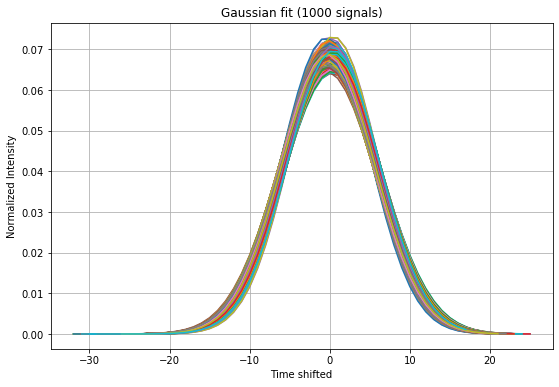

In [16]:
plt.figure(figsize = (9, 6))
for i in range(1000):
    time = np.arange(len(result_evl[i]))
    plt.plot(time - np.argmax(result_evl[i]), result_evl[i]/rvals[i]['amplitude'])
plt.title('Gaussian fit (1000 signals)')
plt.xlabel('Time shifted')
plt.ylabel('Normalized Intensity')
plt.grid()

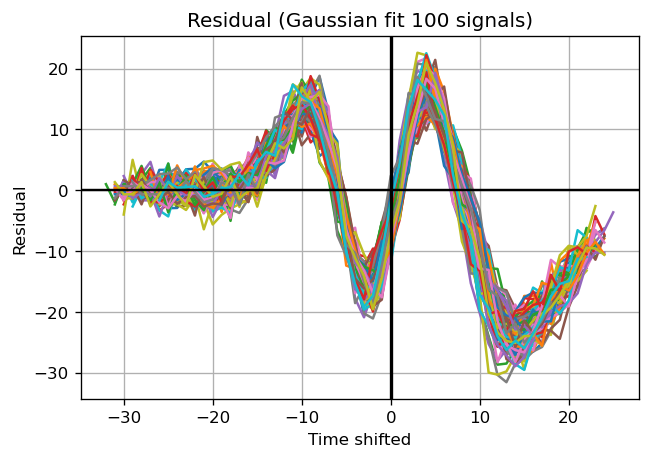

In [10]:
plt.figure(dpi = 120)
for i in range(100):
    time = np.arange(len(rsdl[i]))
    plt.plot(time - np.argmax(result_evl[i]), rsdl[i])
plt.title('Residual (Gaussian fit 100 signals)')
plt.xlabel('Time shifted')
plt.ylabel('Residual')
plt.axvline(x=0, c = 'k', linewidth=2)
plt.axhline(y=0, c = 'k', linewidth=1.45)
plt.grid()

In very simple words, residual is a difference between the original signal and mathematical model (EXP/Gaussian). Looking to residual plot it is possible to see where our fit failed more. In the left tail, it seems that residual is almost 0. In pick, residual is getting closer to 0 too (see the vertical line).

Next step is binning all residuals and doing some simple statistics.

For binning one of the approaches would be grouping residual values according to the signal peak. However, not all outgoing signals have the same shape. Shape generally range between 48 - 56 (for NEON datasets). As we want to have a matrix we have to guess it's size so different shapes will not be a problem. First, we need to find the longest array.

In [11]:
mx = 0
for i in range(len(rsdl)):
    if len(rsdl[i]) > mx:
        mx = len(rsdl[i])

In [12]:
mx

56

The number of rows in our matrix going to be same with the number of signals. The number of columns however requires some solid guess. The longest array's size is 56. However, as the index of the peak is different for different signals when we will group signals according to there peaks 56 might not be enough. In the next cell at line number 3, we are multiplying the difference between the minimum and maximum index numbers with 4 and adding a maximum length of signals (56). This number will be the number of columns in our matrix. 
Next step is to place our signals. Inside our loop, we need 2 conditions. The first condition is needed for placing the first signal in line 8 we are saving the peak of that signal as a reference index. The second condition is for placing other signals according to the peak of the first signal. 

In [13]:
# binning
%time
nan = np.empty((len(rsdl), mx + (max(pik) - min(pik)) * 4))
nan[:] = np.nan
for i in range(len(rsdl)):
    if i == 0:
        nan[i, :][((max(pik) - min(pik)) * 2) : ((max(pik) - min(pik)) * 2 + len(rsdl[i]))] = rsdl[i]
        idx = pik[i] + (max(pik) - min(pik)) * 2
    else:
        pkf = abs(len(rsdl[i][:pik[i]]) - len(nan[i, :][:idx]))
        pkl = - abs(len(rsdl[i][pik[i]:]) - len(nan[i, :][idx:]))
        nan[i, :][pkf:idx] = rsdl[i][:pik[i]]
        nan[i, :][idx:pkl] = rsdl[i][pik[i]:]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


Now as we did binning it is time for some statistics and visualization.

In [14]:
mean = []
std = []
median = []
t_nan = []
for i in range(len(nan)):
    t_nan.append(np.arange(len(nan[i])))
t_nan = np.array(t_nan)
for i in range(nan.shape[1]):
    mn = np.nanmean(nan[:, i])
    st = np.nanstd(nan[:, i])
    md = np.nanmedian(nan[:, i])
    mean.append(mn), std.append(st), median.append(md)

mean = np.array(mean)
median = np.array(median)
std = np.array(std)
print(mean.shape)
pkvl = std[idx]
mean = mean[~np.isnan(mean)]
median = median[~np.isnan(median)]
std = std[~np.isnan(std)]
idx_new = np.where(std == pkvl)[0][0]

(92,)


/home/shaig93/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/shaig93/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/shaig93/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


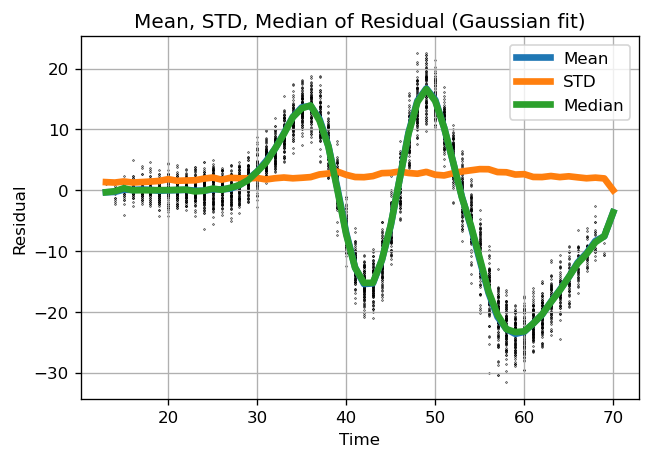

In [16]:
plt.figure(dpi = 120)
s = 100
b = 0
for i in range(100):
    plt.scatter(t_nan[i][~np.isnan(nan[i])], nan[i][~np.isnan(nan[i])],s=0.1, color = 'k')
    if t_nan[i][~np.isnan(nan[i])].min() < s:
        s = t_nan[i][~np.isnan(nan[i])].min()
    if t_nan[i][~np.isnan(nan[i])].max() > b:
        b = t_nan[i][~np.isnan(nan[i])].max()
    
plt.plot(np.arange(s, b+1), mean, label = 'Mean', linewidth = 4)
plt.plot(np.arange(s, b+1), std, label = 'STD', linewidth = 4)
plt.plot(np.arange(s, b+1), median, label = 'Median', linewidth = 4)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.title('Mean, STD, Median of Residual (Gaussian fit)')
plt.grid()

### Exponential Gaussian

In [22]:
thr = 15
BICexp = []
rsdlexp = []
piks = []
rslt_evl = []
rval_ = []
for i in range(len(amp)):
    from lmfit import Model, Parameters
    from lmfit.models import ExponentialGaussianModel
    b = amp[i] - amp[i][:3].mean()
    b = b[b>thr]
    x = np.arange(len(b))[b>thr]
    initial_peak_x = x[np.argmax(b)]
    initial_peak_y = b[np.argmax(b)]
    model = ExponentialGaussianModel() 
    model.set_param_hint('amplitude', value = 10*b.max(), min = 0, max = 1000*b.max())
    model.set_param_hint('center', value = int(initial_peak_x), min = 
                         max(0, x.min()-5), max = x.max()) # center of Gaussian component
    model.set_param_hint('sigma', value = 5, min = 0, max = 10)
    model.set_param_hint('gamma', value = 0.25, min = 0, max = 10)
    model.set_param_hint('offset', value = 0, min = -5, max = 20) 
    param = model.make_params()
    reslt = model.fit(b, param, x = x, nan_policy = 'propagate')
    rvals = reslt.params.valuesdict()
    rval_.append(rvals)
    rsdlexp.append(reslt.residual)
    peaks = np.argmax(reslt.eval())
    rslt_evl.append(reslt.best_fit)
    piks.append(peaks)
    BICexp.append(reslt.bic)

For fitting Exponential Gaussian we took some threshold which is 15. 

Before going into binning and visualizing some inside information would be useful about Exponential Gaussian as it is crucial for the idea of binning. In Gaussian when we were doing binning peak/center was reference which also had the same index with max value (np.argmax() approach). However, in Exponential Gaussian it is not the case. This function is basically convolution of Gaussian and Exponential functions. For peak, we want to have the peak of the Gaussian component. In this case, it is the 'center' parameter from the fit. However, the center is not an index. It is the projection on the x-axis. Problem is for that value there is not a data point on the fit (Figure nr. 4). As we were using an index based binning before it will not work anymore. In this case, integer rounding seems like a good option. However, first, we need to prepare our x-axis (time). We will also normalize 'center' by dividing it to 'sigma' (standard deviation).

In [23]:
t = []
for i in range(len(rsdlexp)):
    t.append((np.arange(len(rsdlexp[i])) - rval_[i]['center'])/rval_[i]['sigma'])
t = np.array(t)

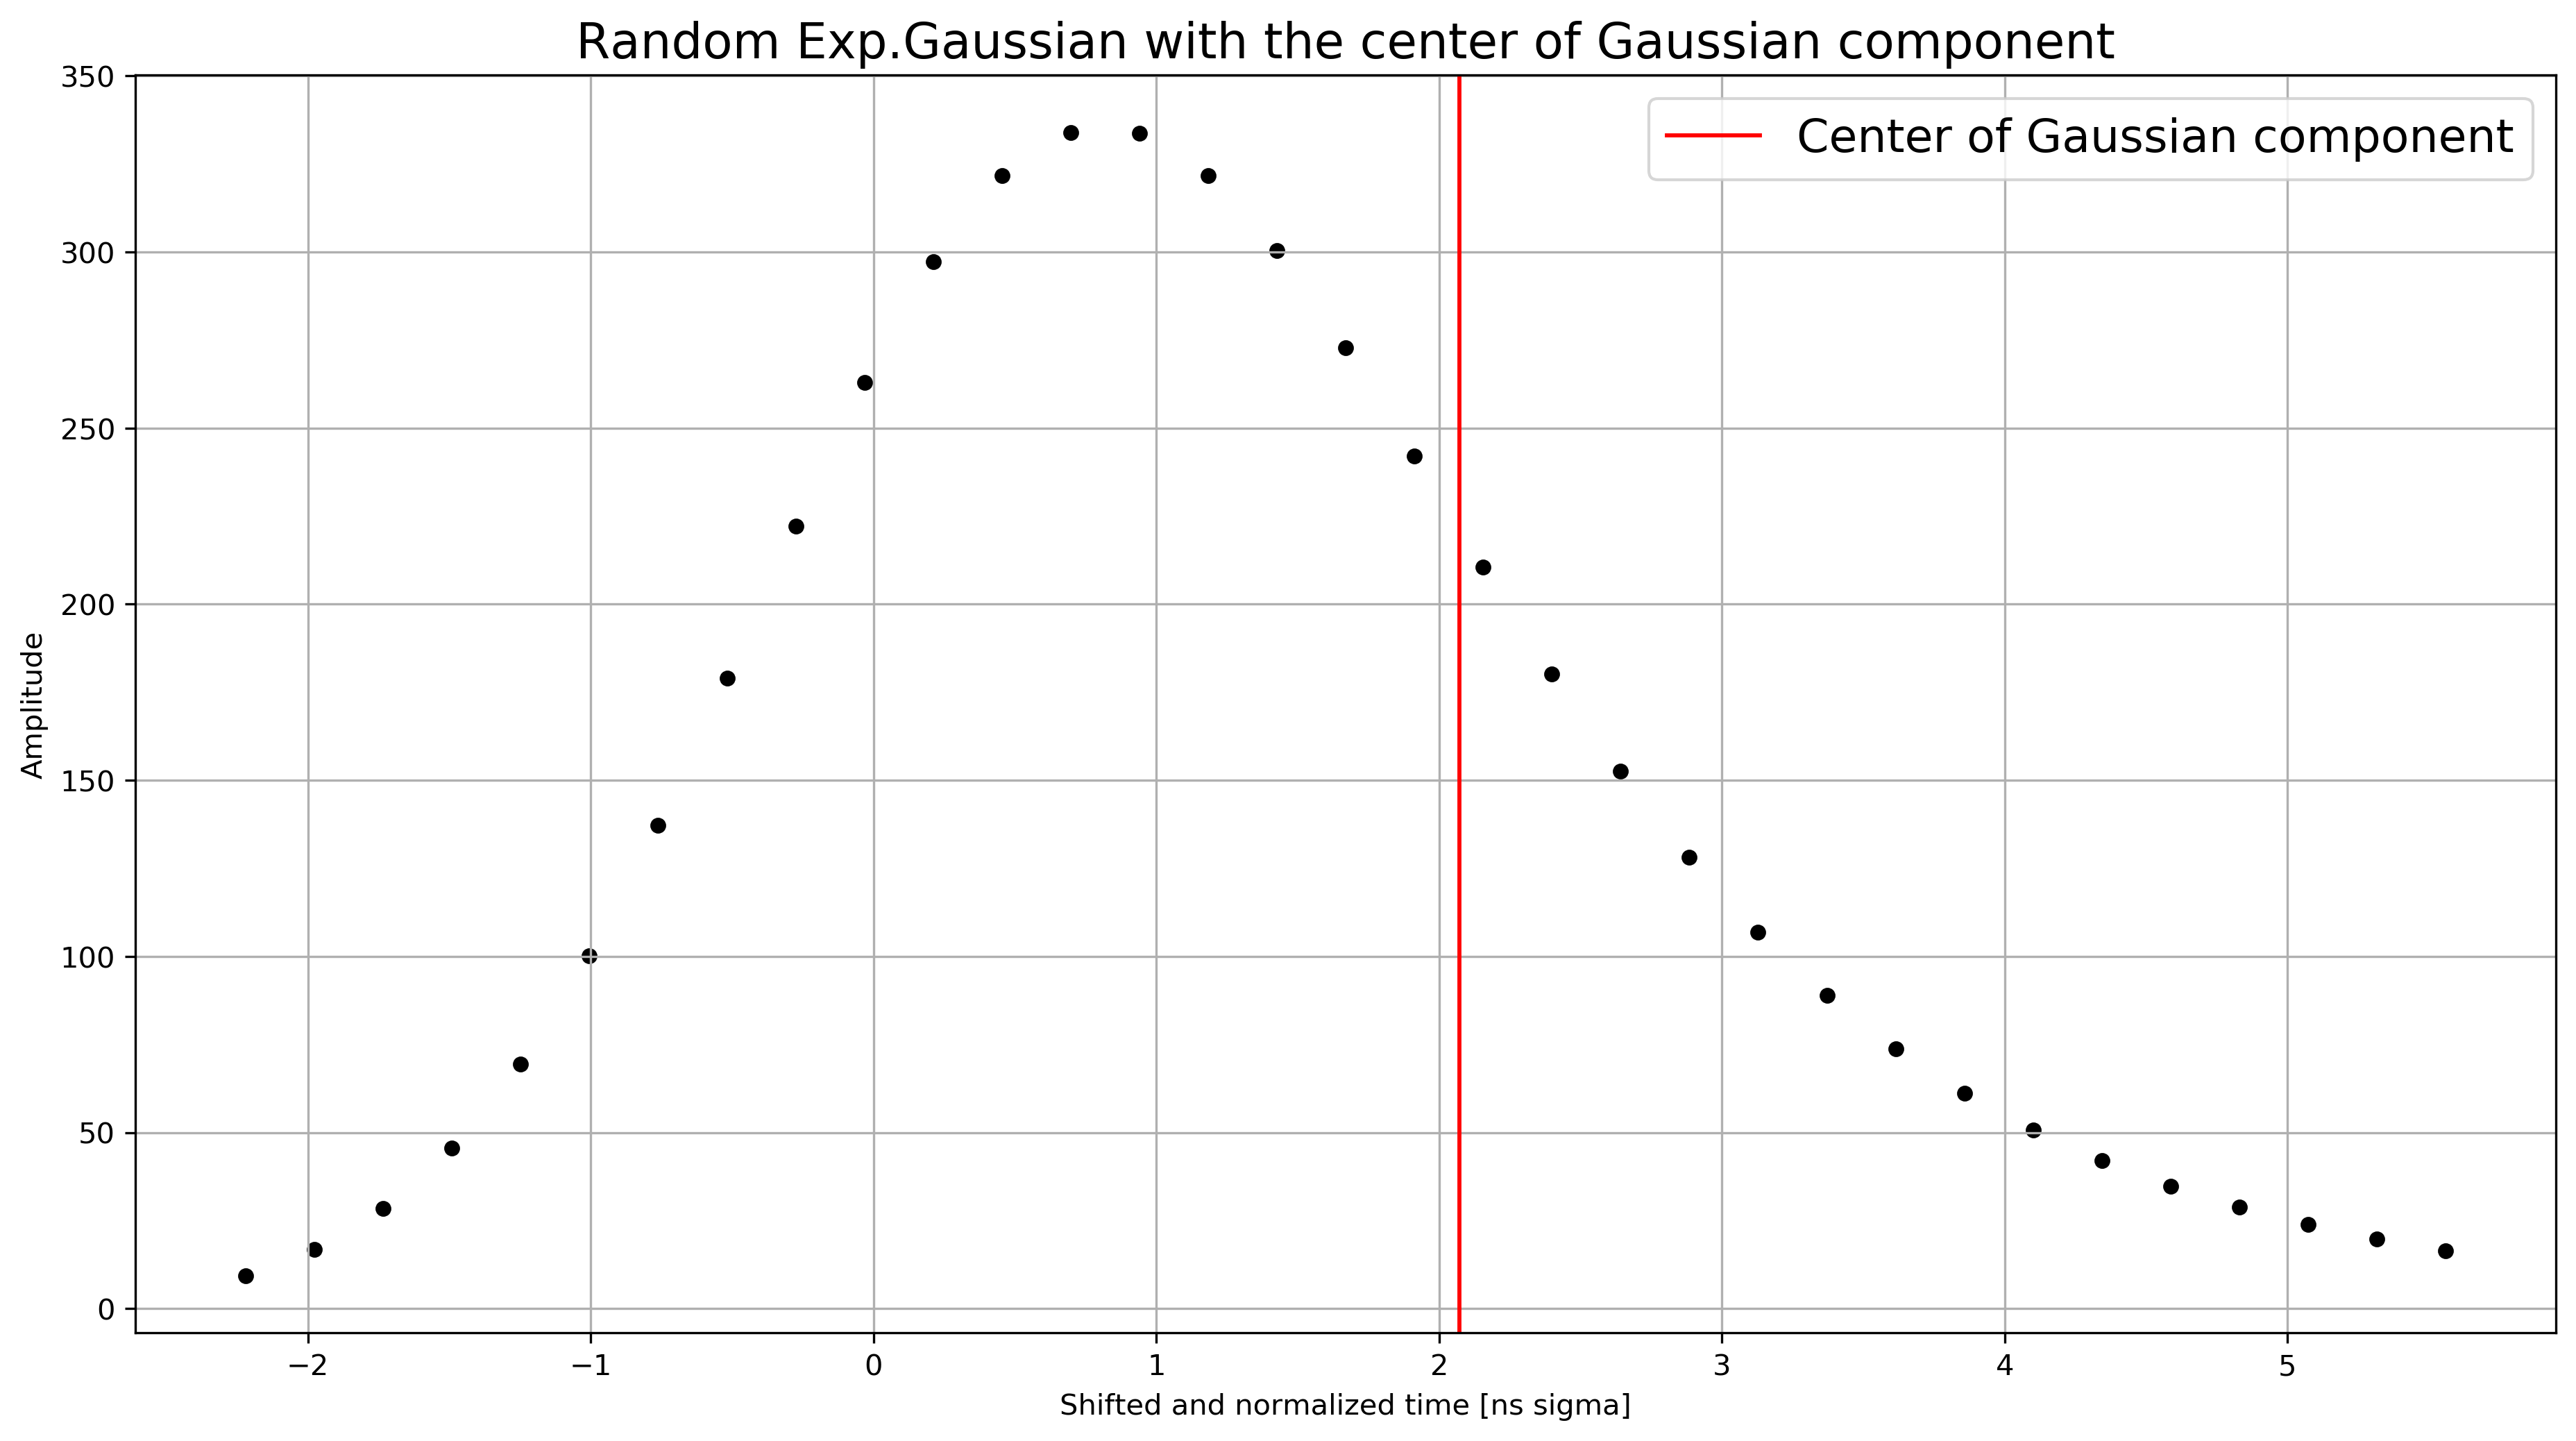

In [24]:
plt.figure(figsize=(15, 8), dpi = 300)
plt.scatter(t[0], rslt_evl[0], s=20, c='k')
plt.axvline(x=rval_[0]['center']/rval_[i]['sigma'], c = 'r', 
            linewidth=1.4, label='Center of Gaussian component')
plt.title('Random Exp.Gaussian with the center of Gaussian component', fontsize=17)
plt.grid()
plt.xlabel('Shifted and normalized time [ns sigma]')
plt.ylabel('Amplitude')
plt.legend(prop={'size': 16})
plt.savefig('compo.png')

In [25]:
mx, mn = 0, 0
for i in range(len(t)):
    if t[i].max() > mx:
        mx = t[i].max()
    if t[i].min() < mn:
        mn = t[i].min()

In [26]:
print('Maximum value of normalized time: ', mx)
print('Minimum value of normalized time: ', mn)

Maximum value of normalized time:  6.411419965881955
Minimum value of normalized time:  -2.4215040884979135


In [27]:
blft = -2.5 # left border of bin
brht = 6.5 # right border of bin
fact = 4
nbin = int((brht-blft) * fact) # number of bins
bedg = np.linspace(blft, brht, nbin + 1) # edges of bins
bwid = bedg[1] - bedg[0] # bin width
bcen = (bedg[1:] + bedg[:-1]) / 2 # center of each bin (array)

In [111]:
bwid

0.25

In [28]:
# Normalizing the amplitude
aa = []
for i in range(len(rslt_evl)):
    aa.append(rslt_evl[i] / rslt_evl[i].max())

The first thing to do is creating indices. In the first line of the next cell first, we are subtracting blft from time. All values in resulting arrays will be positive (minus values are not a good option for indexing). Then by dividing to bwid (0.25) we are trying to distribute the time in a more wide range which will be more suitable for indexing. inside the loop first, we are checking for minus values then we round ti (line 6). 

In [30]:
ti = (t - blft) / bwid # arrays for indexing before rounding
ti[0] # example

array([ 1.12029609,  2.09262958,  3.06496307,  4.03729656,  5.00963005,
        5.98196353,  6.95429702,  7.92663051,  8.898964  ,  9.87129749,
       10.84363098, 11.81596446, 12.78829795, 13.76063144, 14.73296493,
       15.70529842, 16.67763191, 17.6499654 , 18.62229888, 19.59463237,
       20.56696586, 21.53929935, 22.51163284, 23.48396633, 24.45629981,
       25.4286333 , 26.40096679, 27.37330028, 28.34563377, 29.31796726,
       30.29030075, 31.26263423, 32.23496772])

In [31]:
for i in range(len(ti)):
    rsdlexp[i] = rsdlexp[i][ti[i]>=0]
    aa[i] = aa[i][ti[i]>=0]
    ti[i] = ti[i][ti[i] >= 0]
    ti[i] = ti[i].astype('int')
    t[i] = t[i][ti[i] >= 0]
    t[i] = t[i][ti[i] < nbin]
    rsdlexp[i] = rsdlexp[i][ti[i] < nbin]
    aa[i] = aa[i][ti[i] < nbin]
    ti[i] = ti[i][ti[i] < nbin]

In [120]:
ti[0] # exemplary array after rounding

array([ 1,  2,  3,  4,  5,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

Rounded time values will be indices of bin lists. 

In [32]:
bins = [[] for i in range(nbin)] # creating list of empty lists/bins residuals
for i in range(len(rsdlexp)):
    for j in range(len(ti[i])):
            bins[ti[i][j]].append(rsdlexp[i][j]) # each j'th residual value in i'th array is being appended 
                                                # to a bin based on rounded i'th time (index) value

In [33]:
binsa = [[] for i in range(nbin)] # creating list of empty lists/bins amplitudes
for i in range(len(aa)):
    for j in range(len(ti[i])):
            binsa[ti[i][j]].append(aa[i][j])# each j'th amplitude value in i'th array is being appended 
                                                # to a bin based on rounded i'th time (index) value 

In [34]:
# Doing statiscs for residual and amplitude bins
mean = np.nan * np.ones(nbin)
stdr = np.nan * np.ones(nbin)
pc50 = np.nan * np.ones(nbin)
pc75 = np.nan * np.ones(nbin)
pc25 = np.nan * np.ones(nbin)
meana = np.nan * np.ones(nbin)
stdra = np.nan * np.ones(nbin)
pc50a = np.nan * np.ones(nbin)
pc95a = np.nan * np.ones(nbin)
pc5a = np.nan * np.ones(nbin)
for i in range(len(bins)):
    if len(bins[i]) == 0: # as some bins might be empty we need to ignore them
        continue
    mean[i] = np.mean(bins[i])
    stdr[i] = np.std(bins[i])
    pc50[i] = np.median(bins[i])
    pc75[i] = np.percentile(bins[i], 75)
    pc25[i] = np.percentile(bins[i], 25)
    meana[i] = np.mean(binsa[i])
    stdra[i] = np.std(binsa[i])
    pc50a[i] = np.median(binsa[i])
    pc95a[i] = np.percentile(binsa[i], 95)
    pc5a[i] = np.percentile(binsa[i], 5)

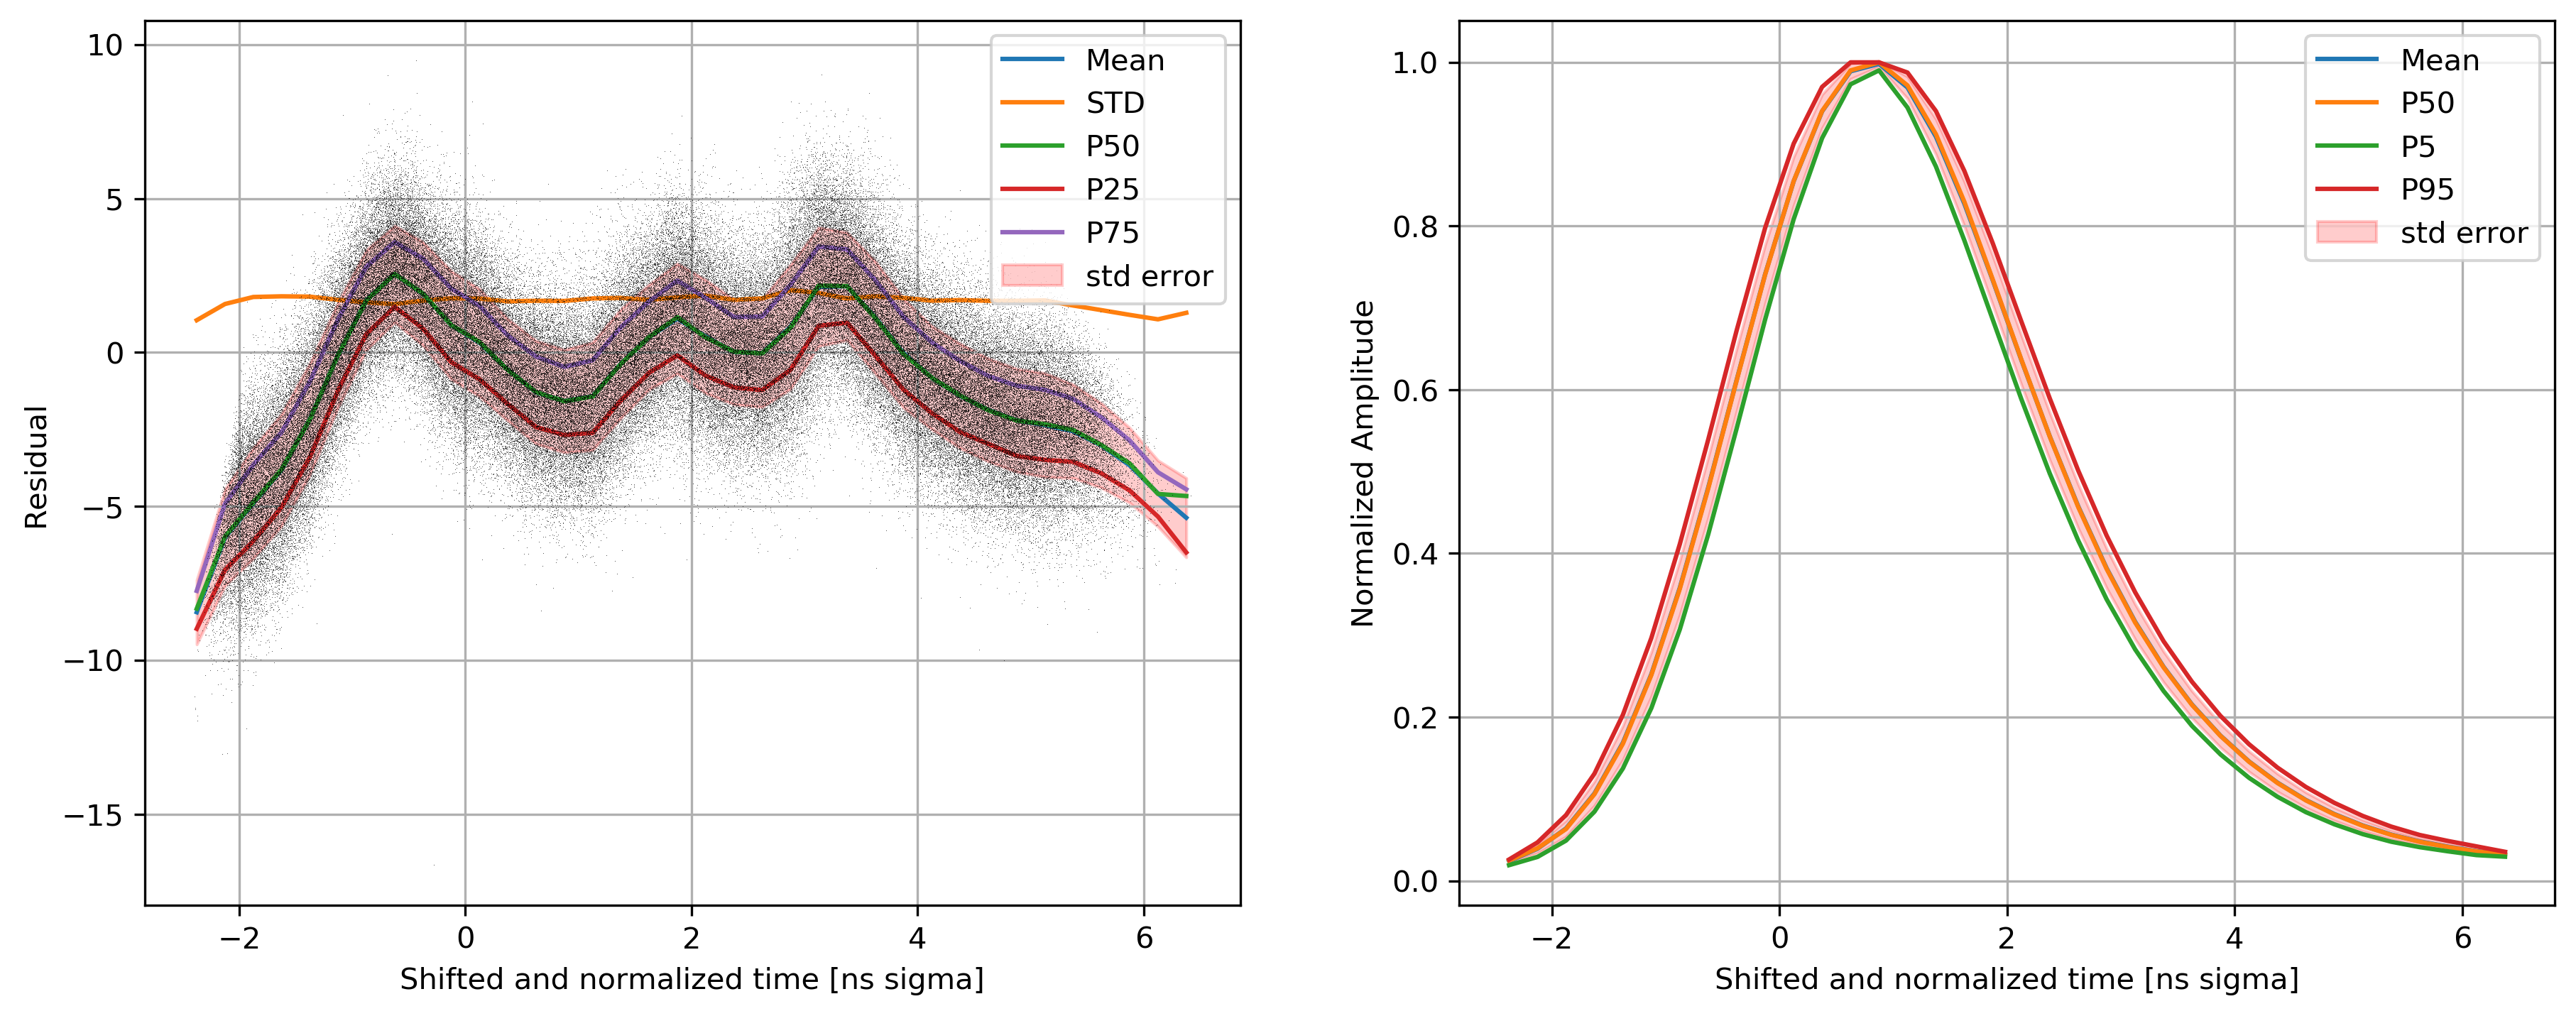

In [40]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14.6, 5.5), dpi = 300)
ax[0].plot(bcen, mean, label = 'Mean')
ax[0].plot(bcen, stdr, label = 'STD')
ax[0].plot(bcen, pc50, label = 'P50')
ax[0].plot(bcen, pc25, label = 'P25')
ax[0].plot(bcen, pc75, label = 'P75')
ax[1].plot(bcen, meana, label = 'Mean')
ax[1].plot(bcen, pc50a, label = 'P50')
ax[1].plot(bcen, pc5a, label = 'P5')
ax[1].plot(bcen, pc95a, label = 'P95')
for i in range(6000):
    ax[0].plot(t[i], rsdlexp[i], ',', color = 'k', alpha = 0.65)
ax[0].fill_between(bcen, mean - stdr, mean + stdr, color = 'red', alpha = 0.2, label = 'std error')
ax[1].fill_between(bcen, meana - stdra, meana + stdra, color = 'red', alpha = 0.2, label = 'std error')
ax[0].set_ylabel('Residual')
ax[0].set_xlabel('Shifted and normalized time [ns sigma]')
ax[1].set_ylabel('Normalized Amplitude')
ax[1].set_xlabel('Shifted and normalized time [ns sigma]')
ax[0].grid()
ax[1].grid()
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')
plt.savefig('Residual&ExpGaussian', dpi=300)

### Conclusion

Exponential Gaussian perform better than Gaussian. Gaussian model fits better on the left tail (mean of residual is almost zero) aside that Exponential Gaussian performs better. For getting rid of tail problem it is also possible to choose bigger threshold.

It must be noted that this is only outgoing signal which has less noise that returning signal (returning signal also has multiple returns) which made this investigation considerably easy.